# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [3]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from panel.interact import interact
from dotenv import load_dotenv

In [4]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [5]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
sfo_data.head()
file_path = Path("Data/neighborhoods_coordinates.csv")
location_data = pd.read_csv(file_path, index_col= "Neighborhood")
location_data.head()


,Lat,Lon
Neighborhood,,
Alamo Square,37.791012,-122.402100
Anza Vista,37.779598,-122.443451
Bayview,37.734670,-122.401060
Bayview Heights,37.728740,-122.410980
Bernal Heights,37.728630,-122.443050


- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [26]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housing_units_year = sfo_data.groupby(['year']).mean('housing_units')
    housing_units_year.drop(['sale_price_sqr_foot','gross_rent'], axis = 1, inplace = True)
    housing_units_year.reindex()
    max_units_year = max(housing_units_year['housing_units']) + 3000
    min_units_year = min(housing_units_year['housing_units']) -3000
    housing_units_plot = housing_units_year.plot.bar(xlabel= "Year", ylabel = "Housing units", ylim=(min_units_year, max_units_year), title = "Housing Units in San Francisco from 2010 to 2016")
    return housing_units_plot


def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    avg_rent = sfo_data["gross_rent"].groupby([sfo_data.index]).mean()
    avg_rent_plot = avg_rent.plot(
        xlabel = 'Year', 
        ylabel= 'Gross rent', 
        color = 'green',
        title="Average gross rent by year",figsize=(5,5))
    return avg_rent_plot


def average_sales_price():
    """Average Sales Price Per Year."""
    avg_sale_price = sfo_data['sale_price_sqr_foot'].groupby([sfo_data.index]).mean()
    avg_price_plot = avg_sale_price.plot(
        xlabel = 'Year', 
        ylabel= 'Price per sq foot', 
        color = 'red',
        title = 'Average Sale Price per Square Foot by year',figsize=(5,5))
    return avg_price_plot  


def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    sfo_neighborhood = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean().reset_index()
    average_price_by_neighborhood_plot = sfo_neighborhood.hvplot.line(
        x="year",
        y="sale_price_sqr_foot",
        color ="green",
        groupby = "neighborhood",
        title="SF Sale per Square foot per Year",
    )
    return average_price_by_neighborhood_plot
 
           
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    sfo_neighborhood_top10 = sfo_data.groupby('neighborhood')['sale_price_sqr_foot'].mean().reset_index()
    sfo_neighborhood_ten = sfo_neighborhood_top10.sort_values('sale_price_sqr_foot', ascending = False).reset_index()
    sfo_neighborhood_10 = sfo_neighborhood_ten.head(10)
    top_neighborhood_plot = sfo_neighborhood_10.plot.bar(
        x='neighborhood',
        xlabel = 'Neighborhood', 
        y = 'sale_price_sqr_foot',
        ylabel= 'Sale_price_sqr_foot', 
        color = "green",
        title="Top 10 suburbs by price per sqr foot",figsize=(5,5)
    )
    return top_neighborhood_plot

def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    sfo_neighborhood = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean().reset_index()
    most_expensive_neighborhood_plot = sfo_neighborhood.hvplot.bar(
        x = 'year',
        y= ['sale_price_sqr_foot', 'gross_rent'],
        xlabel = 'Year',
        ylabel = 'Dollars',
        title= 'Comparison- SF average monthly rent versus average price per sqr mtr',
        rot = 90)
    return most_expensive_neighborhood_plot



""    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    sfo_neighborhood_top = sfo_data.groupby([sfo_data.index, 'neighborhood']).mean()
    sfo_neighborhood_top = sfo_neighborhood_top.nlargest(10, 'sale_price_sqr_foot')
    sfo_neighborhood_top.head()
    return px.parallel_coordinates(sfo_neighborhood_top, color= sfo_neighborhood_top.index)

def parallel_categories():
    """Parallel Categories Plot."""
    sfo_neighborhood_top = sfo_data.groupby([sfo_data.index, 'neighborhood']).mean().reset_index()
    sfo_neighborhood_top = sfo_neighborhood_top.nlargest(10,'sale_price_sqr_foot')
    sfo_neighborhood_top10_plot = px.parallel_categories(
        sfo_neighborhood_top10,
        dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
        color="year",
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            "neighborhood": "Neighborhood",
            "sale_price_sqr_foot": "Sale price per sqr foot",
            "housing_units": "Housing units",
            "gross_rent": "Gross rent",
        },
        width=1200,
)
    return sfo_neighborhood_top10_plot
        


def neighborhood_map():
    """Neighborhood Map."""
    load_dotenv()
    map_box_api = os.getenv("MAPBOX_KEY")
    px.set_mapbox_access_token(map_box_api)
    sf_avg_all = sfo_data.groupby(['neighborhood']).mean()
    loc_and_avg_df = pd.concat([location_data, sf_avg_all], axis = "columns", join = "inner")
    map_plot = px.scatter_mapbox(
        loc_and_avg_df,
        lat="Lat",
        lon="Lon",
        size="gross_rent",
        color="sale_price_sqr_foot",
        title="Average Sale Price per Square Foot and Gross Rent in San Francisco",
        zoom = 10,
        width = 1000)
    return map_plot

def sunburst():
    """Sunburst Plot."""
    fig = px.sunburst(sfo_neighborhood_top, path=[
    'year', 'neighborhood'], values='sale_price_sqr_foot', color = 'gross_rent', width=500, height=500)           
    return fig.show()
""    


''

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

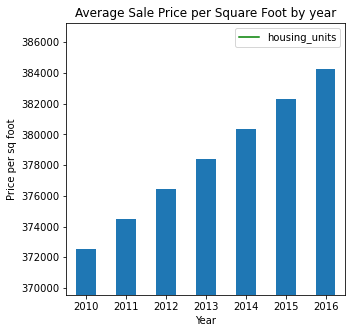

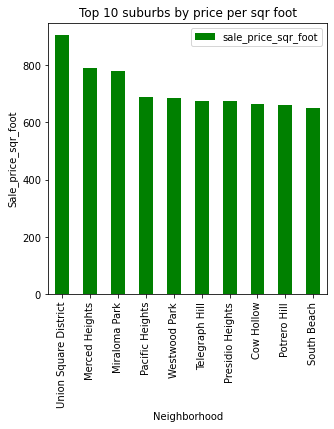

In [31]:
title = pn.pane.Markdown(
    """
# Real Estate Analysis of San Francisco from 2010-2016
""",
    width=600,
)
market_charts = pn.Row('## Market Analysis', housing_units_per_year(), average_gross_rent(), average_sales_price())
neighborhood_charts = pn.Row('## Neighborhood Analysis',average_price_by_neighborhood(), 
    top_most_expensive_neighborhoods(), most_expensive_neighborhoods_rent_sales())
#parallel_plots_tab = pn.column('## Parallel Plots', parallel_coordinates(),parallel_categories())
# Create tabs
sfo_realestate = pn.Tabs(
    ("Market Analysis", market_charts),
    ("Neighborhood Analysis", neighborhood_charts)
)
#panel = pn.Column(pn.Row(title), sfo_realestate, width=900)


## Serve the Panel Dashboard

In [33]:
# Serve the# dashboard
sfo_realestate.servable()

Tabs
    [0] Row
        [0] Markdown(str)
        [1] Str(AxesSubplot)
        [2] Str(AxesSubplot)
        [3] Str(AxesSubplot)
    [1] Row
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [2] Str(AxesSubplot)
        [3] HoloViews(Bars)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

<AxesSubplot:title={'center':'Housing Units in San Francisco from 2010 to 2016'}, xlabel='Year', ylabel='Housing units'>

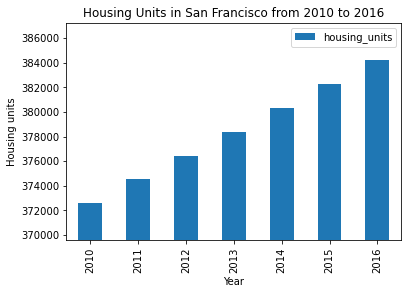

In [27]:
housing_units_per_year()

<AxesSubplot:title={'center':'Average gross rent by year'}, xlabel='Year', ylabel='Gross rent'>

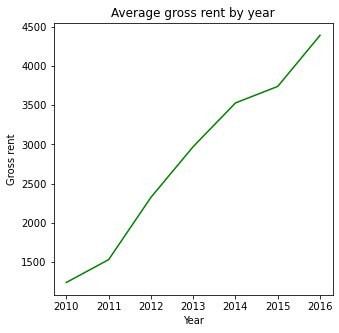

In [28]:
average_gross_rent()

<AxesSubplot:title={'center':'Average Sale Price per Square Foot by year'}, xlabel='Year', ylabel='Price per sq foot'>

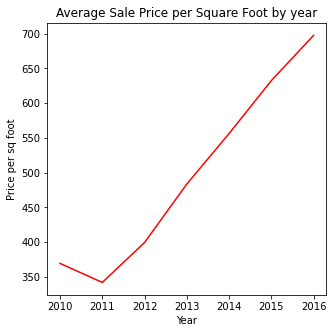

In [29]:
average_sales_price()

In [34]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

<AxesSubplot:title={'center':'Top 10 suburbs by price per sqr foot'}, xlabel='Neighborhood', ylabel='Sale_price_sqr_foot'>

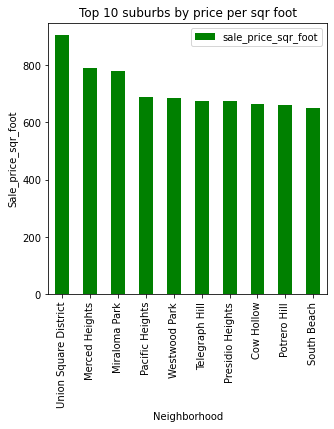

In [35]:
top_most_expensive_neighborhoods()

In [45]:
most_expensive_neighborhoods_rent_sales()

:Bars   [year,Variable]   (value)

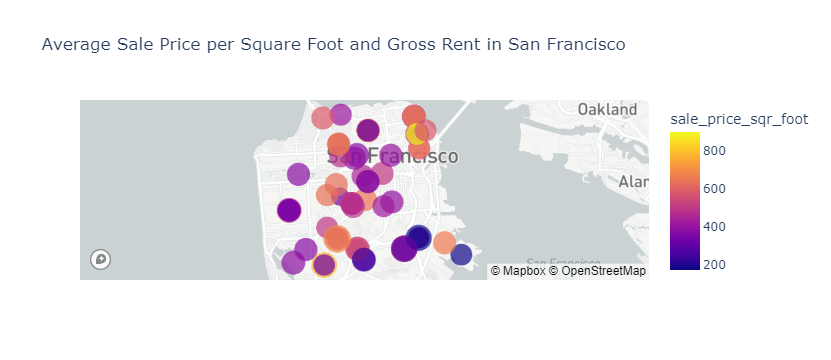

In [46]:
neighborhood_map().show()

In [38]:
parallel_categories()
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    sfo_neighborhood_top = sfo_data.groupby([sfo_data.index, 'neighborhood']).mean()
    sfo_neighborhood_top = sfo_neighborhood_top.nlargest(10, 'sale_price_sqr_foot')
    sfo_neighborhood_top.head()
    return px.parallel_coordinates(sfo_neighborhood_top, color= sfo_neighborhood_top.index)

def parallel_categories():
    """Parallel Categories Plot."""
    sfo_neighborhood_top = sfo_data.groupby([sfo_data.index, 'neighborhood']).mean().reset_index()
    sfo_neighborhood_top = sfo_neighborhood_top.nlargest(10,'sale_price_sqr_foot')
    sfo_neighborhood_top10_plot = px.parallel_categories(
        sfo_neighborhood_top10,
        dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
        color="year",
        color_continuous_scale=px.colors.sequential.Inferno,
        labels={
            "neighborhood": "Neighborhood",
            "sale_price_sqr_foot": "Sale price per sqr foot",
            "housing_units": "Housing units",
            "gross_rent": "Gross rent",
        },
        width=1200,
)
    return sfo_neighborhood_top10_plot

NameError: name 'sfo_neighborhood_top10' is not defined

In [35]:
parallel_coordinates()

NameError: name 'sfo_neighborhood_top_10' is not defined

In [36]:
sunburst()

NameError: name 'sfo_neighborhood_top' is not defined